In [3]:
import h5py
from string import Template
import numpy as np
import scipy
import os
from matplotlib import pyplot as plt, cm
!pip install pyestimate
from pyestimate import sin_param_estimate

def integrate_q(data,q,q_roi, norm_sum):
    """checked by Christian"""
    q_start, q_stop = q_roi
    start_index = np.where(q>=q_start)[0][0]
    stop_index = np.where(q>=q_stop)[0][0]
    azimutal_integrated = np.sum(data[...,start_index:stop_index]*norm_sum[:,start_index:stop_index] ,axis=(2,3))
    norm = np.sum(norm_sum[:,start_index:stop_index], axis=(0,1))
    output = np.divide(azimutal_integrated ,norm , out=np.zeros_like(azimutal_integrated))
    return output

def load_data(proposal,visit,scan, det, cluster='maxiv'):
    """keys in file that will be loaded
        **FROM AZINT FILE**
        'I' : cake plot from radial integration, ordering (image,azimuthal,q) 
        'azi', : azimuthal bins
        'mask_file', : file path for mask used for radial integration
        'norm', : weights/norm sum for computing averages for integrated data, (azimuthal and q)
        'polarization_factor', : polarisation factor used for integration
        'poni_file', : file path for pony file
        'q', : q Vektor for integration
        **FROM MASTER FILE**
        'i_t', : diode data, transmittance for 2D map
        'dt' : exposure time from eiger/lambda/diode
        'title' :  scan command from SPOCK
        'swaxs_x' : swaxs_x stage position (encoder reading)
        'swaxs_y' : swaxs_y stage position (theoretical reading)
        'swaxs_rot' : swaxs_y stage position (theoretical reading)
        'time' : time point for triggers for exposure
    """
    if cluster == 'maxiv':
        fname = '/data/visitors/formax/%s/%s/process/azint/scan-%04d_%s_integrated.h5' %(proposal, visit, scan, det)
    elif cluster == 'lunarc':
        fname = '/projects/maxiv/visitors/formax/%s/%s/process/azint/scan-%04d_%s_integrated.h5' %(proposal, visit, scan, det)
    else:
        print("Clustername is not recognised")
        
    data = {}
    items = {
         'I': 'entry/data2d/cake',
         'q': 'entry/data1d/q',
         'azi' : 'entry/data2d/azi',
         'mask_file':'entry/azint/input/mask_file',
         'norm':'entry/data2d/norm',
         'polarization_factor':'entry/azint/input/polarization_factor',
         'poni':'entry/azint/input/poni',   
    }
    with h5py.File(fname, 'r') as fh:
        for key, name in items.items():
            if name in fh:
                data[key] = fh[name][()]  
            
    # master file
    master = fname.replace('process/azint', 'raw')
    master = master.replace('_%s_integrated' %det, '')
    items = {
        'i_t': 'entry/instrument/albaem-e01_ch1/data',   
         'title': 'entry/title'                       
    }
    with h5py.File(master, 'r') as fh:
        for key, name in items.items():
            if name in fh:
                data[key] = fh[name][()]

    # fly or step scan
    if fly_scan == True:
        data['shape'] = (int((str(data['title']).split(' '))[8])+1, int((str(data['title']).split(' '))[4]))
    else:
        data['shape'] = (int((str(data['title']).split(' '))[8])+1, int((str(data['title']).split(' '))[4])+1)
    return data


Defaulting to user installation because normal site-packages is not writeable


# Parameters (to be defined by user)

In [133]:
scan = 230
proposal = 20240661
visit = 2024102408
#det = 'eiger' # Pick 'eiger' or 'lambda'
#q_range = (0.0288,0.030) # Select q_range = (q_min,q_max) for q-dependent plot
#q_range = ()

det = 'lambda'
q_range = (1.59,1.64)
#q_range = (1.70,1.80)

# Data processing

In [134]:

#Reading scan parameters
fname = '/data/visitors/formax/%s/%s/raw/scan-%04d.h5' %(proposal, visit, scan)
fh = h5py.File(fname, 'r')
title_str = str(fh['entry/title'][()]).split(' ')

if title_str[0][2:] == 'meshct_maxiv':
    fly_scan = True
else:
    fly_scan = False
        
if title_str[10][0:4] == 'True':
    snake_scan = True
else:
    snake_scan = False

    
#Loading data
data = load_data(proposal,visit,scan,det)

# absorption contrast
I = data['i_t'].reshape(data['shape'])
I_flipped = np.copy(I)
if snake_scan == True:
    I_flipped[1::2,:] = I_flipped[1::2,::-1]
absorption = I_flipped


# dark field
I = data['I'].reshape((data['shape'][0],data['shape'][1],data['azi'].shape[0],data['q'].shape[0]))

I_flipped = np.copy(I)
if snake_scan == True:
    I_flipped[1::2,:,:,:] = I_flipped[1::2,::-1,:,:]
data_scat = I_flipped
total_scattering = np.average(data_scat,axis=(2,3))

q = data['q']
norm_sum = data['norm']

#Defining q ranges for background subtraction
q_bg1 = (q_range[0]-(q_range[1]-q_range[0]),q_range[0]) 
q_bg2 = (q_range[1],q_range[1]+(q_range[1]-q_range[0])) 

ind_q = list(np.where((q>q_range[0]) & (q<q_range[1]))[0])
ind_bg1 = list(np.where((q>q_bg1[0]) & (q<q_bg1[1]))[0])
ind_bg2 = list(np.where((q>q_bg2[0]) & (q<q_bg2[1]))[0])

#print(len(ind_q))
#print(len(ind_bg1))
#print(len(ind_bg2))

# q dependent, background subtracted
image = integrate_q(data_scat,q,q_range,norm_sum)  - 0.5*((len(ind_q)/len(ind_bg1))*integrate_q(data_scat,q,q_bg1,norm_sum) + (len(ind_q)/len(ind_bg2))*integrate_q(data_scat,q,q_bg2,norm_sum))


IndexError: list index out of range

# Plotting

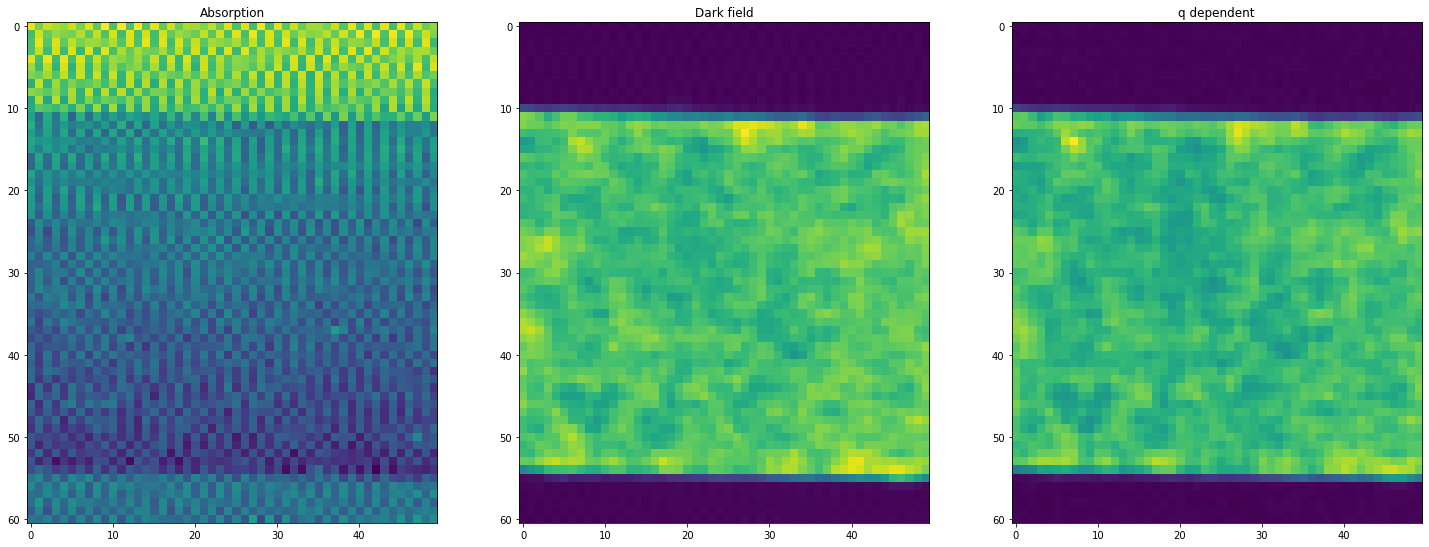

In [135]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(25,10))

# absorption
ax1.imshow(absorption)
ax1.title.set_text('Absorption')

# dark field
ax2.imshow(total_scattering)
ax2.title.set_text('Dark field')

#q dependent
ax3.imshow(image)
ax3.title.set_text('q dependent')


# Orientation analysis

### Data processing

(1, 135)
(3050, 180)
41.54518669676717
0.06547012252804915
0.17010874122005593


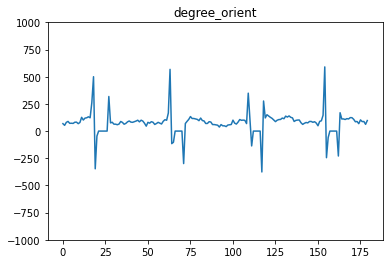

In [136]:
#Defining angular range for background fitting (to subtract gaps) 
ind_ang = np.array([np.arange(0,26)])


ind_ang1 = np.array([np.arange(0,26)])
ind_ang2 = np.array([np.arange(66,113)])
ind_ang3 = np.array([np.arange(118,180)])

ind_ang = np.concatenate((ind_ang1,ind_ang2),axis=1)
ind_ang = np.concatenate((ind_ang,ind_ang3),axis=1)
print(ind_ang.shape)

#Background subtraction and cropping
data_azi = np.sum(data_scat[:,:,:,ind_q],axis=3) - 0.5*((len(ind_q)/len(ind_bg1))*np.sum(data_scat[:,:,:,ind_bg1],axis=3)+(len(ind_q)/len(ind_bg2))*np.sum(data_scat[:,:,:,ind_bg2],axis=3)) 
data_azi = np.vstack(data_azi)
print(data_azi.shape)




A,f,phi = sin_param_estimate(data_azi[1000,:])
#A,f,phi = sin_param_estimate(data_azi[3049,:])
#A,f,phi = sin_param_estimate(data_azi[5314,:])

print(A)
print(f)
print(phi)


plt.figure()
plt.plot(data_azi[1000,:])
#plt.plot(2*ind_ang, data_azi[3049, ind_ang])
#plt.plot(data_azi[5314,:])
#plt.plot(A*np.cos(2*np.pi*n*f+phi), 'r--')
plt.title('degree_orient')
plt.ylim([-1000,1000])
plt.show()




# Test of smoothing the data and interpolating missing values

In [137]:
print(data.keys())
print(data["q"].shape)
print(data["I"].shape) #3050 = 61*50, then 180 is every azimuthal angle, then 2000 for q

dict_keys(['I', 'q', 'azi', 'mask_file', 'norm', 'polarization_factor', 'poni', 'i_t', 'title', 'shape'])
(2000,)
(3050, 180, 2000)


## Smoothing the data with spline

Some scan position is chosen and the azimuthal angle. 
Then the I vs q curve is plotted. This is noisy so we are interested in smoothing out the noise.
There is also missing data at the range where no sensor is present. The missing data at the beginning and end can be removed. In the middle, when the data is missing set the weight to zero.

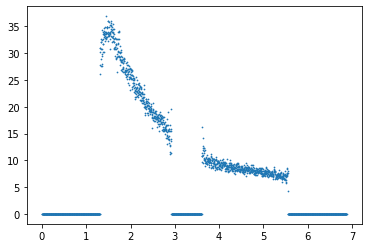

In [138]:
#only background = 79



I_vec = data["I"][5,80]
q_vec = data["q"]


plt.scatter(q_vec,I_vec,s = 0.5)

#Weight vector
w = (I_vec != 0)*1





In [139]:
from scipy.interpolate import splrep, BSpline, splev


379
1615


Text(0, 0.5, 'I')

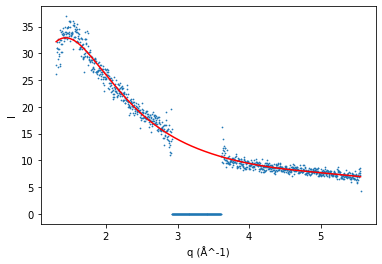

In [140]:
#Crop the beginning and the end part where the data is zero
indx_start = np.argmax(w)
indx_end = len(w) - np.argmax(np.flip(w)) 
print(indx_start)
print(indx_end)


q_vec2 = q_vec[indx_start:indx_end]
I_vec2 = I_vec[indx_start:indx_end]
w2 = w[indx_start:indx_end]

tck = splrep(q_vec2,I_vec2, w = w2, s = 1200)
I_smooth = splev(q_vec2,tck)

plt.plot(q_vec2,I_smooth,color = 'red')
plt.scatter(q_vec2,I_vec2,s = 0.5)
plt.xlabel("q (Å^-1)")
plt.ylabel("I")

## Smoothing the data with a low degree polynomial

Idea : smoothing splines work well but there is a lot of parameters, making it difficult to compare different curves mathematically.
3rd degree regression on the data

We loose locality on the other hand so the fit may not be perfect

In [141]:
print(tck)

(array([1.30707512, 1.30707512, 1.30707512, 1.30707512, 1.84005627,
       2.36959884, 3.43212256, 5.5537314 , 5.5537314 , 5.5537314 ,
       5.5537314 ]), array([32.16387409, 34.24823631, 28.80380706, 16.71118095,  8.26125903,
        8.07708992,  6.96874454,  0.        ,  0.        ,  0.        ,
        0.        ]), 3)


[ -0.32397871   4.17153879 -16.51774019  12.84302953  37.88578383]


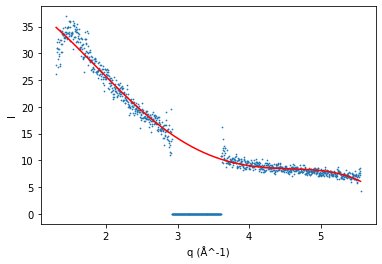

In [142]:
z = np.polyfit(q_vec2,I_vec2,w = w2,deg = 4)
p = np.poly1d(z)

I_smooth_poly = p(q_vec2)

plt.plot(q_vec2,I_smooth_poly,color = 'red')
plt.scatter(q_vec2,I_vec2,s = 0.5)
plt.xlabel("q (Å^-1)")
plt.ylabel("I")

print(z)